In [56]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
import sklearn.metrics as m
from collections import Counter

In [57]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def nn_model(localdf,localdict,times,metric,num_cols):
    for counter in range(times):
        for i in range(num_cols):
            df = pd.DataFrame()
            if(i != 0):
                print(localdf.columns[i])
                df = localdf[localdf.columns[i]]
                ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                ndf.columns = ('t-2', 't-1', 't')
                ndf = ndf.iloc[2:]

                x = ndf[ndf.columns[0:2]]
                y = ndf[ndf.columns[-1:]]

                X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                model = Sequential()
                model.add(Dense(5,input_dim=2,kernel_initializer='normal', activation='relu'))
                #Output Layer.
                model.add(Dense(1,kernel_initializer='normal'))
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=200,batch_size=200,verbose=1)
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1)
                y_pred = model.predict(X_test)
                
                #Plot of training history.
                plt.figure()
                plt.plot(y_test)
                plt.plot(y_pred)
                plt.legend()
                plt.show()
                
                #print (str(coeff_determination(y_test,y_pred)))
                print ("Metric : %.5f" % (scores[1]))
                localdict.setdefault(counter,[]).append((scores[1]))
                model.summary()
    return localdict,history

In [58]:
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    scores.append(m.r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [68]:
df=pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
df_new=df
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        pos.append(i)
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range(len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b

df.drop(df.columns[[10,21,25]],inplace=True,axis=1)
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]

df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2

'''
for k in range(df_thermal.values.shape[0]-1):
    if(k!=0):
        df_thermal.values[k+1] = df_thermal.values[k] + df_thermal.values[k+1]
print(df_thermal)
'''
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + d0f_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [93]:
df=pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
for i in df.columns:
    if df[i].isnull().sum() >=40995 :
        del df[i]

del df['drye1']
del df['lights_plugs3']
del df['range1']
df.shape
df = pd.DataFrame(df.values[175:],columns=df.columns)
df

,dataid,localhour,use,air1,air2,air3,bathroom1,clotheswasher1,dishwasher1,disposal1,...,grid,kitchenapp1,kitchenapp2,lights_plugs1,lights_plugs2,microwave1,outsidelights_plugs1,outsidelights_plugs2,refrigerator1,waterheater1
0,1632,2013-03-23 08:00:00-05,0.466633,0,0,0,0,0,0.0042,0,...,0.466633,0.01735,0.0015,0.011,0,0.0207167,0,0.0958833,NaN,0
1,1632,2013-03-23 09:00:00-05,0.503983,0,0,0,0,0,0.00411667,0,...,0.503983,0.00531667,0.00135,0.01085,0,0.008,0,0.0954167,NaN,0
2,1632,2013-03-23 10:00:00-05,0.561033,0,0,0,0,0,0.00406667,0,...,0.561033,0.000316667,0.00145,0.00926667,0,0.008,0,0.0947167,NaN,0.181567
3,1632,2013-03-23 11:00:00-05,1.68328,0,0,0,0,0,0.0037,0,...,1.68328,0,0.00195,0.0076,0,0.008,0,0.09305,NaN,1.32477
4,1632,2013-03-23 12:00:00-05,0.36605,0,0,0,0,0,0.00433333,0,...,0.36605,0,0.0009,0,0,0.008,0,0.095,NaN,0
5,1632,2013-03-23 13:00:00-05,0.279767,0,0,0,0,0,0.0033,0,...,0.279767,0,0.00155,0,0,0.008,0,0.0954667,NaN,0
6,1632,2013-03-23 14:00:00-05,0.38075,0,0,0,0,0,0.0046,0,...,0.38075,0,0.00055,0,0,0.008,0,0.0955167,NaN,0
7,1632,2013-03-23 15:00:00-05,0.289817,0,0,0,0,0,0.00313333,0,...,0.289817,0.00188333,0.0027,0,0,0.008,0,0.0961333,NaN,0
8,1632,2013-03-23 16:00:00-05,0.415717,0,0,0,0,0,0.00478333,0,...,0.415717,0.00015,0.00135,0,0,0.00806667,0,0.09745,NaN,0
9,1632,2013-03-23 17:00:00-05,0.299333,0,0,0,0,0,0.00343333,0,...,0.299333,0,0.00295,0,0,0.00806667,0,0.09845,NaN,0


In [69]:
df_thermal_total = df_thermal[['localhour','total_thermal_load']]
df_thermal_total.columns = ['localhour','total_thermal_load']

total_thermal_load
Epoch 1/200
28572/28572 [==============================] - 0s - loss: 0.8245 - mean_squared_error: 0.8245     
Epoch 2/200
28572/28572 [==============================] - 0s - loss: 0.3993 - mean_squared_error: 0.3993     
Epoch 3/200
28572/28572 [==============================] - 0s - loss: 0.2657 - mean_squared_error: 0.2657     
Epoch 4/200
28572/28572 [==============================] - 0s - loss: 0.2237 - mean_squared_error: 0.2237     
Epoch 5/200
28572/28572 [==============================] - 0s - loss: 0.2123 - mean_squared_error: 0.2123     
Epoch 6/200
28572/28572 [==============================] - 0s - loss: 0.2088 - mean_squared_error: 0.2088     
Epoch 7/200
28572/28572 [==============================] - 0s - loss: 0.2072 - mean_squared_error: 0.2072     
Epoch 8/200
28572/28572 [==============================] - 0s - loss: 0.2065 - mean_squared_error: 0.2065     
Epoch 9/200
28572/28572 [==============================] - 0s - loss: 0.2062 - mean_squared_e

28572/28572 [==============================] - 0s - loss: 0.2057 - mean_squared_error: 0.2057     
Epoch 73/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 74/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 75/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055     
Epoch 76/200
28572/28572 [==============================] - 0s - loss: 0.2057 - mean_squared_error: 0.2057     
Epoch 77/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 78/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 79/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055      ETA: 0s - loss: 0.2084 - mean_squar
Epoch 80/200
28572/28572 [==============================] - 0s - loss: 0.2056 - m

28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 145/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055     
Epoch 146/200
28572/28572 [==============================] - 0s - loss: 0.2054 - mean_squared_error: 0.2054     
Epoch 147/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 148/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055     
Epoch 149/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056     
Epoch 150/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055     
Epoch 151/200
28572/28572 [==============================] - 0s - loss: 0.2055 - mean_squared_error: 0.2055     
Epoch 152/200
28572/28572 [==============================] - 0s - loss: 0.2056 - mean_squared_error: 0.2056   

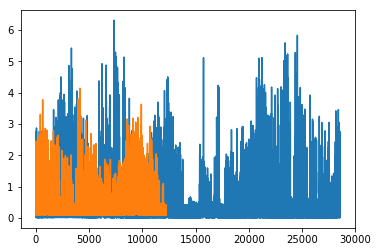

Metric : 0.14335
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


ValueError: not enough values to unpack (expected 2, got 1)

In [71]:
thermal_dict = {}
ti = time.time()
thermal_dict,model_hist = nn_model(df_thermal_total,thermal_dict,1,"mean_squared_error")
tf = time.time()
print ("Time Taken : ",tf-ti)
print (thermal_dict)

In [ ]:
thermal_dict = {}
ti = time.time()
thermal_dict = et_2hours(df_thermal_total)
tf = time.time()
print ("Time Taken : ",tf-ti)
print (thermal_dict)